Copyright ENEOS corporation as contributors to Matlantis contrib project

# Notebook3_応用編

本NotebookはMatlantis内tutorialの"NEB"をベースに、遷移状態計算などの項目を追加したものです。

# 目次
[NEB法による反応経路探索の準備](#NEB法による反応経路探索の準備)  
[必要なモジュールの読み込み](#必要なモジュールの読み込み)  
[NEB法を使用した反応経路探索](#NEB法を使用した反応経路探索)  
[遷移状態計算](#遷移状態計算)  
[振動計算](#振動計算)  
[IRC計算](#IRC計算)

## 必要なモジュールの読み込み

In [1]:
import ase
from ase import Atoms
from ase.visualize import view
from ase.optimize import BFGS, FIRE                                     #FIREは新規
from ase.neb import NEB                                                 #新規
from ase.build.rotate import minimize_rotation_and_translation          #新規

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator

estimator = Estimator(model_version='v2.0.0')                           #version指定を推奨
calculator = ASECalculator(estimator)

import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

import os
os.makedirs("output/", exist_ok=True)

# NEB法による反応経路探索の準備

今回はクルチウス転位と呼ばれる有機化学反応を題材として、ASEに実装されている反応経路探索手法である**NEB**(Nudged Elastic Band)法を実行します。  
NEB法は反応の**始状態(react, IS)と終状態(prod, FS)** を用意し、それらをつなぐ推定経路を生成・緩和を行う手法です。  
まずはISとFSを用意し、構造最適化を行います。

※NEB法では幾つか必ず満たすべき条件があります。  
①ISとFSで原子数が同じ  
②ISとFSで、Atomsオブジェクト内の元素の順番が同じ  
 (Chem3Dなどで分子を作成すると順番がずれていて、エラーになる場合があり、注意が必要です) 

In [2]:
react = ase.Atoms(            #直接構造を指定
    symbols="C2NON2H3",
    positions = [
        [ 2.12, -0.48,  0.00],
        [ 0.76,  0.16, -0.00],
        [-0.28, -0.79, -0.00],
        [ 0.57,  1.35,  0.00],
        [-1.42, -0.28,  0.00],
        [-2.48,  0.07,  0.00],
        [ 2.67, -0.14, -0.88],
        [ 2.06, -1.57, -0.00],
        [ 2.67, -0.14,  0.88],
    ],
)

prod = ase.Atoms(
    symbols="C2NON2H3",
    positions=[
        [ 2.30, -0.87,  0.00],
        [ 0.68,  0.92, -0.00],
        [ 0.99, -0.25,  0.00],
        [ 0.25,  2.03,  0.00],
        [-2.34,  0.11,  0.00],
        [-3.13, -0.67, -0.00],
        [ 2.87, -0.57, -0.89],
        [ 2.19, -1.96,  0.00],
        [ 2.87, -0.57,  0.89],
    ],
)

与えた2つの構造から推定して中間点(beads)を生成するため、  
反応前後の2つの座標が近くなるよう、最適化後構造の位置移動も行います。

In [3]:
react.calc = calculator
opt = BFGS(react)
opt.run(fmax=0.01)

prod.calc = calculator
opt = BFGS(prod)
opt.run(fmax=0.01)

minimize_rotation_and_translation(react, prod) #RMSD(平均二乗偏差)を最小にするように第2引数を動かす

      Step     Time          Energy         fmax
BFGS:    0 00:53:15      -41.288288        3.3720
BFGS:    1 00:53:15      -41.050356        9.2272
BFGS:    2 00:53:16      -41.352635        0.9379
BFGS:    3 00:53:16      -41.360421        0.8468
BFGS:    4 00:53:16      -41.367069        0.4149
BFGS:    5 00:53:16      -41.370912        0.2225
BFGS:    6 00:53:17      -41.373644        0.1877
BFGS:    7 00:53:17      -41.374698        0.1327
BFGS:    8 00:53:17      -41.376002        0.1432
BFGS:    9 00:53:17      -41.377715        0.1950
BFGS:   10 00:53:18      -41.379424        0.1925
BFGS:   11 00:53:18      -41.380616        0.1081
BFGS:   12 00:53:18      -41.381476        0.0848
BFGS:   13 00:53:18      -41.382040        0.0993
BFGS:   14 00:53:19      -41.382359        0.0638
BFGS:   15 00:53:19      -41.382590        0.0515
BFGS:   16 00:53:19      -41.382831        0.0601
BFGS:   17 00:53:19      -41.383157        0.0738
BFGS:   18 00:53:20      -41.383480        0.0659
B

可視化のスクリプトも下に置いておきます。可視化ウィンドウ内のバーを操作すると反応前後の構造を切り替えできます。

In [4]:
v = view([react, prod], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

# NEB法を使用した反応経路探索
準備が完了しましたのでNEB法の出番です。中間点の補完やNEBの実行はASEの実装を使用します。  
`allow_shared_calculator=False`,`parallel=True`を指定し、並列計算することでより高速に経路探索が可能です。

NEBは複数の構造を内部で使う手法のため、MD計算と比較してもステップあたりの計算時間は大きくなります。  
それでもPFPを使えば、数分で終わらせることができます。

In [5]:
images = [react.copy()]
images += [react.copy() for i in range (7)] #中間点には暫定的にreactの構造を入れておく
images += [prod.copy()]
for image in images:
    image.calc = ASECalculator(estimator)
neb = NEB(images, k=0.1, parallel=True, climb=True, allow_shared_calculator=False) #NEBの設定
neb.interpolate()                           #中間点はここで補完
opt = FIRE(neb)
status = opt.run(fmax=0.05, steps=500)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 00:53:58      -38.198985*      23.5055
FIRE:    1 00:53:59      -39.254653*       6.5079
FIRE:    2 00:53:59      -39.008497*      11.1646
FIRE:    3 00:54:00      -39.405801*       7.0583
FIRE:    4 00:54:00      -39.450011*       6.9047
FIRE:    5 00:54:01      -39.462430*       5.3536
FIRE:    6 00:54:01      -39.478967*       3.7186
FIRE:    7 00:54:02      -39.489772*       3.0160
FIRE:    8 00:54:02      -39.491193*       2.8975
FIRE:    9 00:54:03      -39.488363*       3.9157
FIRE:   10 00:54:03      -39.488606*       4.0392
FIRE:   11 00:54:04      -39.495301*       3.5120
FIRE:   12 00:54:05      -39.507830*       2.8098
FIRE:   13 00:54:05      -39.519271*       1.8177
FIRE:   14 00:54:06      -39.525183*       3.2659
FIRE:   15 00:54:06      -39.539542*       2.8927
FIRE:   16 00:54:07      -39.572488*       1.9629
FIRE:   17 00:54:07      -39.604982*       2.3038
FI

もしログを抑制したい場合は、`FIRE(neb, logfile=None)`のような指定をするとデフォルトのoptのログが表示されなくなります。

NEBの各点のエネルギーをプロットし、エネルギーの軌跡を確認します。
左端がreact、右端がprodで、エネルギー最大の点と左右の安定点それぞれとのエネルギー差が活性化エネルギーに相当します。

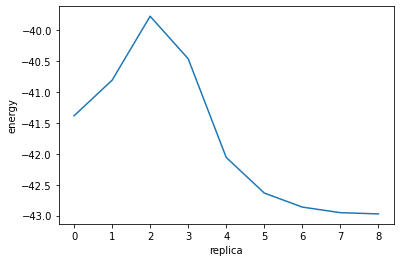

In [6]:
energies = [image.get_total_energy() for image in images]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(energies)
ax.set_xlabel("replica")
ax.set_ylabel("energy")
fig.show()

構造についても同様に出力を行います。NEBの結果は構造1つではなく、GIFで一組の軌跡として出力することができます。

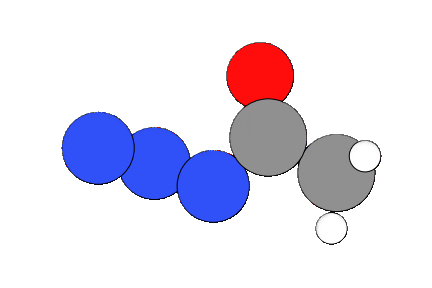

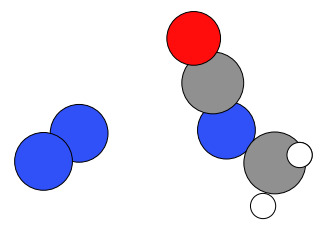

In [7]:
ase.io.write("output/curtius_NEB.gif", images, format="gif")
Image(data=open("output/curtius_NEB.gif", "rb").read(), format='gif') #GIFをNotebook内で表示

上には最終構造の静止画が表示されていると思いますが、左のファイルビューアから"curtius_NEB.gif"をダブルクリックして開くと直接アニメーションGIFを見ることができます。

正常に計算が実行されていれば、以下のようなアニメーションGIFが見られます。

![curtius_NEB.gjf](assets/curtius_NEB.gif)

以下のようにしてファイルの中身をここに表示することもできます。

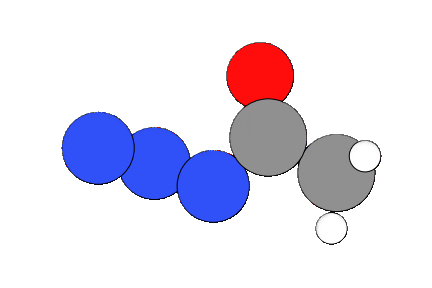

In [9]:
Image(data=open("output/curtius_NEB.gif", "rb").read(), format='gif') #GIFをNotebook内で表示

# 遷移状態計算
遷移状態計算の手法として、ここではSellaという、ASE関連パッケージを使用します。
まず初めにインストールを行います(2回目以降は実行不要です)。

In [9]:
!pip install sella

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.matlantis-common.svc:8080/simple
Note: you may need to restart the kernel to use updated packages.


NEBで得られた、エネルギーの最も高い構造を初期構造として用います。
実行方法は基本的に構造最適化と同様です。

In [10]:
from sella import Sella, Constraints
TSNo = 2                 #NEBの経路内でエネルギー最大の点を指定
TS = images[TSNo].copy()
TS.calc = calculator
TSopt = Sella(TS)
TSopt.run(fmax=0.01)

     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 00:57:30      -39.772249       0.0127       0.0000       0.0273       1.0000
[51.21245208] [10.91762773] [4.69080403] 0
[5.6344919] [1.03657674] [5.43567271] 0
[9.25717119] [0.20732456] [44.65062462] 0
[12.28617223] [-3.63348424] [-3.38137485] 0
[10.58326321] [-13.6832051] [-0.77344914] 0
[3.75537209] [-15.29339696] [-0.24555513] 0
Sella   1 00:57:35      -39.772489       0.0241       0.0000       0.0273       1.1545
Sella   2 00:57:35      -39.772509       0.0092       0.0000       0.0273       1.5987


True

In [11]:
v = view([images[TSNo], TS], viewer='ngl') #最適化前後での構造変化を確認
v.view.add_representation("ball+stick")
display(v)

# 振動解析
得られた最適化構造が正しい遷移状態であるかは、振動解析で虚振動が一つであるかを確認する必要があります。  
振動計算の実行方法と、結果の出力についてご説明します。  
振動計算では大量の中間ファイルが生成するため、中間ファイル用のディレクトリを新しく作ることを推奨します。

In [12]:
import os
from ase.vibrations import Vibrations
path = "output/TS_vib/vib"
os.makedirs(path, exist_ok=True) #中間ファイル用のディレクトリを作成
vib = Vibrations(TS, name=path)
vib.run()
vib_energies = vib.get_energies()
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   72.1i    581.6i
  1    0.7i      5.6i
  2    0.5i      4.1i
  3    0.2i      1.4i
  4    0.1i      1.2i
  5    0.1       0.6
  6    1.1       8.9
  7   15.9     128.3
  8   17.2     138.4
  9   26.5     213.8
 10   34.6     279.4
 11   34.7     279.6
 12   47.2     380.7
 13   67.8     546.7
 14   73.9     595.9
 15   83.8     676.0
 16  110.3     889.8
 17  111.8     901.4
 18  142.0    1145.2
 19  154.5    1246.4
 20  173.3    1397.8
 21  174.2    1405.2
 22  224.3    1809.2
 23  290.7    2344.3
 24  369.8    2982.9
 25  382.1    3082.0
 26  383.8    3095.8
---------------------
Zero-point energy: 1.460 eV


安定構造では虚振動が存在しないこと、遷移状態では(大きな)虚振動が1つであることを確認してください。  
※今回の構造で出力される1~4は振動ではなく、回転・並進ですので無視できます  
次に振動モードの確認方法です。ここでは確認したい振動モードをTrajファイルで出力します。


In [13]:
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io.trajectory import Trajectory
n = 0      # summary tableを参照して表示したい振動モードの番号を入力
vib.write_mode(n=n, kT=300*kB, nimages=30) # 指定振動モードの表示用のtrajファイルを出力
vib.clean() # vibのスクラッチファイルクリア
path = "output/TS_vib/vib"
vib_traj = Trajectory(path + "." + str(n)+ ".traj")
v = view(vib_traj, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

ここで振動方向に対して遷移状態構造のエネルギーが極大値となっていることを確認してください。
両端とvib_traj[15]が遷移状態です。

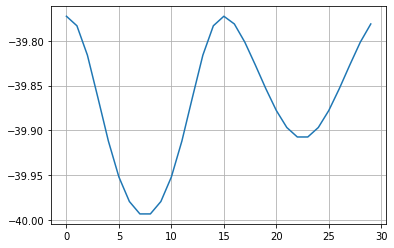

In [14]:
vib_energies = [] 
for i in vib_traj:                                #vib_trajはどの振動モードのものか注意
    i.calc = calculator
    vib_energies.append(i.get_potential_energy())
plt.plot(range(len(vib_energies)), vib_energies)  #Trajファイルの各点のエネルギーをプロット
plt.grid(True)
plt.show()

# IRC計算
ASEを用いたIRC計算の実行について説明します。  
先ほど実行した振動計算の、遷移状態(vib_traj[15])の両隣の構造から構造最適化を実行することで、振動方向へとPESを下ることができます。

In [15]:
forIS = vib_traj[14].copy() #反応に関与する2原子間距離でISとFSを判断する
forIS.calc = calculator
BFGS_opt = BFGS(forIS, logfile=None)
BFGS_opt.run(fmax=0.01)
forFS = vib_traj[16].copy()
forFS.calc = calculator
BFGS_opt = BFGS(forFS, logfile=None)
BFGS_opt.run(fmax=0.01)

True

最後に、NEB計算で得られた経路と疑似的IRC計算で得られた経路の構造とエネルギーを確認します。
(同様にIS,TSについても比較を行ってください)

In [16]:
v = view([images[0], forIS], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [17]:
v = view([images[TSNo], TS], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [18]:
v = view([images[-1], forFS], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

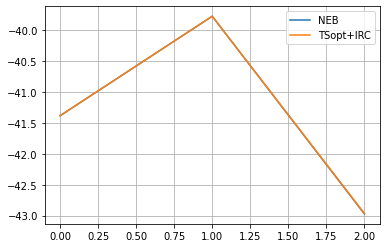

In [19]:
plt.plot([0,1,2], [images[0].get_potential_energy(), images[TSNo].get_potential_energy(), images[-1].get_potential_energy()], label="NEB")
plt.plot([0,1,2], [forIS.get_potential_energy(), TS.get_potential_energy(), forFS.get_potential_energy()], label="TSopt+IRC")
plt.legend()
plt.grid(True)
plt.show()

今回の系ではほぼ同一の経路が得られたことが構造・エネルギーの両面からわかります。  
※想定とは別の構造が得られる場合、振動モードをn=0のもの以外を指定している場合があるのでご確認ください。
